# Convolutional Neural Network Using MFCC Classifying Gender

Garrett Faucher

In [1]:
from keras.callbacks import EarlyStopping
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
audio_data = np.load("../data/audio_data.npy")
labels = np.load("../data/wav_labels.npy")

# labels: modality-vocal channel-emotion-emotional intensity-statement-repetition-actor
# emotions: 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# odd number actors = male, even = female

# 1440 files: 24 speakers, 60 recordings per speaker
audio_data = audio_data.reshape(1440, 9480)

features = []

for i in range(1440):
    
    if (labels[i][6]%2 == 0):
        label = 1
    else:
        label = 0
    
    features.append([audio_data[i], label])
    
feature_df = pd.DataFrame(features, columns = ["mfcc", "gender"])

feature_df.head()

,mfcc,gender
0,"[-855.3770751953125, -855.3770751953125, -855....",0
1,"[-850.3917236328125, -850.435791015625, -850.4...",0
2,"[-849.78369140625, -848.8447265625, -848.56610...",0
3,"[-842.9385375976562, -843.2474975585938, -850....",0
4,"[-911.1758422851562, -910.4053344726562, -905....",0


In [3]:
## ===== Males ===== ##
X = np.array(feature_df.mfcc.tolist())
y = np.array(feature_df.gender.tolist())

#20-80 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Reshape for CNN input
X_train = np.array([x.reshape( (20, 474, 1) ) for x in X_train])
X_test = np.array([x.reshape( (20, 474, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(to_categorical(y_train, 2))
y_test = np.array(to_categorical(y_test, 2))

## CNN Architechture

In [4]:
model = Sequential()

model.add(Conv2D(64, (5,5), input_shape=X_test.shape[1:], kernel_regularizer=l2(l=0.01)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(24, (4,4)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.1))

model.add(Conv2D(24, (3,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.2))

model.add(Conv2D(80, (2,2)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate=0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(rate=0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [5]:
opt = Adam(learning_rate=0.0001)

model.compile(
	optimizer=opt,
	loss="categorical_crossentropy",
	metrics=['accuracy']
)

history = model.fit(
	x=X_train,
	y=y_train,
    epochs=150,
    batch_size=75,
    validation_data= (X_test, y_test),
	callbacks=[EarlyStopping(monitor='loss', patience=3)],
	verbose=0
)

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 0s 6ms/step - loss: 0.0565 - accuracy: 0.9931
Test loss: 0.05654379352927208
Test accuracy: 0.9930555820465088


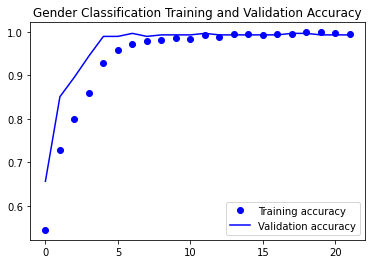

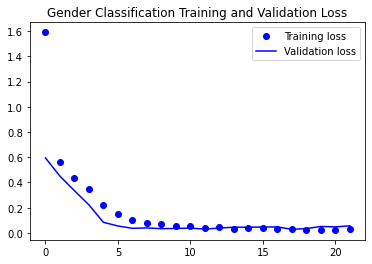

In [6]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Gender Classification Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Gender Classification Training and Validation Loss')
plt.legend()
plt.show()